# Leopard challenge Classification

## Загрузка данных
Данные беру из leopard-challenge-classification.zip
https://drive.google.com/file/d/1OYjGYeYQzKI3mE02ymtkrbRJb5EurpL7/view?usp=sharing

# Colab

In [ ]:
! gdown --id 1OYjGYeYQzKI3mE02ymtkrbRJb5EurpL7

! unzip /content/leopard-challenge-classification.zip -d /content/leopard-challenge-classification/

In [ ]:
! unzip / content / leopard-challenge-classification.zip -d / content / leopard_challenge_classification /

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/leopard_challenge_classification/train.csv')

In [ ]:
df.head()

In [ ]:
!pip install phik

!pip install feature_engine

!pip install catboost

# Pycharm

In [ ]:
from zipfile import ZipFile

with ZipFile('leopard-challenge-classification.zip', 'r') as zf:
    zf.extractall()

# 1. Задача

Дан набор данных с основными клиническими показателями людей.
Каждая строчка в датасете - клинические показатели одного человека - рост, вес, зрение и т.д.
**Задача:** Определить, курит человек или нет, на основании его показателей.

# 2. Импорт библиотек

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
import phik
import folium
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.imputation import RandomSampleImputer
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, log_loss
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, cv
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import warnings

warnings.filterwarnings("ignore")
# plt.style.use('dark_background')
plt.style.use('seaborn-colorblind')
pd.set_option('display.max_columns', 100)

# 3. Загрузка Датасета

In [3]:
df = pd.read_csv('train.csv')

In [4]:
df.head()

,ID,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,oral,dental caries,tartar,smoking
0,2791,65,170,75,91.0,0.6,0.9,1.0,1.0,122.0,79.0,107.0,119.0,51.0,71.0,52.0,14.0,3.0,1.2,20.0,16.0,122.0,Y,0,N,0
1,18280,35,170,85,97.0,1.5,1.5,1.0,1.0,138.0,88.0,117.0,204.0,239.0,46.0,120.0,14.6,1.0,0.7,20.0,25.0,40.0,Y,0,Y,1
2,1618,70,165,55,75.0,0.8,1.0,1.0,1.0,115.0,63.0,128.0,165.0,60.0,68.0,85.0,14.7,1.0,0.7,15.0,13.0,19.0,Y,0,Y,0
3,16856,35,180,85,83.0,1.2,1.0,1.0,1.0,130.0,80.0,100.0,209.0,155.0,53.0,125.0,17.2,1.0,0.8,22.0,18.0,17.0,Y,0,Y,0
4,5885,25,170,65,80.0,1.5,1.2,1.0,1.0,135.0,75.0,94.0,153.0,73.0,58.0,80.0,16.5,1.0,1.0,20.0,13.0,14.0,Y,0,Y,1


In [5]:
df.shape

(13863, 26)

In [6]:
df_test = pd.read_csv('test.csv')

In [7]:
df.head()

,ID,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,oral,dental caries,tartar,smoking
0,2791,65,170,75,91.0,0.6,0.9,1.0,1.0,122.0,79.0,107.0,119.0,51.0,71.0,52.0,14.0,3.0,1.2,20.0,16.0,122.0,Y,0,N,0
1,18280,35,170,85,97.0,1.5,1.5,1.0,1.0,138.0,88.0,117.0,204.0,239.0,46.0,120.0,14.6,1.0,0.7,20.0,25.0,40.0,Y,0,Y,1
2,1618,70,165,55,75.0,0.8,1.0,1.0,1.0,115.0,63.0,128.0,165.0,60.0,68.0,85.0,14.7,1.0,0.7,15.0,13.0,19.0,Y,0,Y,0
3,16856,35,180,85,83.0,1.2,1.0,1.0,1.0,130.0,80.0,100.0,209.0,155.0,53.0,125.0,17.2,1.0,0.8,22.0,18.0,17.0,Y,0,Y,0
4,5885,25,170,65,80.0,1.5,1.2,1.0,1.0,135.0,75.0,94.0,153.0,73.0,58.0,80.0,16.5,1.0,1.0,20.0,13.0,14.0,Y,0,Y,1


In [8]:
df_test.shape

(5942, 25)

# 4. Получение информации о Датасете

## 4.1 Подготовка таблиц

### Перевод названий колонок в строчные буквы и замена пробелов

In [9]:
df.head()

,ID,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,oral,dental caries,tartar,smoking
0,2791,65,170,75,91.0,0.6,0.9,1.0,1.0,122.0,79.0,107.0,119.0,51.0,71.0,52.0,14.0,3.0,1.2,20.0,16.0,122.0,Y,0,N,0
1,18280,35,170,85,97.0,1.5,1.5,1.0,1.0,138.0,88.0,117.0,204.0,239.0,46.0,120.0,14.6,1.0,0.7,20.0,25.0,40.0,Y,0,Y,1
2,1618,70,165,55,75.0,0.8,1.0,1.0,1.0,115.0,63.0,128.0,165.0,60.0,68.0,85.0,14.7,1.0,0.7,15.0,13.0,19.0,Y,0,Y,0
3,16856,35,180,85,83.0,1.2,1.0,1.0,1.0,130.0,80.0,100.0,209.0,155.0,53.0,125.0,17.2,1.0,0.8,22.0,18.0,17.0,Y,0,Y,0
4,5885,25,170,65,80.0,1.5,1.2,1.0,1.0,135.0,75.0,94.0,153.0,73.0,58.0,80.0,16.5,1.0,1.0,20.0,13.0,14.0,Y,0,Y,1


In [10]:
df.columns = df.columns.str.replace(' ', '_').str.replace('(', '_').str.replace(')', '_').str.lower()
df_test.columns = df_test.columns.str.replace(' ', '_').str.replace('(', '_').str.replace(')', '_').str.lower()

## 4.2 Основная информация о датасете

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13863 entries, 0 to 13862
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   13863 non-null  int64  
 1   age                  13863 non-null  int64  
 2   height_cm_           13863 non-null  int64  
 3   weight_kg_           13863 non-null  int64  
 4   waist_cm_            13863 non-null  float64
 5   eyesight_left_       13863 non-null  float64
 6   eyesight_right_      13863 non-null  float64
 7   hearing_left_        13863 non-null  float64
 8   hearing_right_       13863 non-null  float64
 9   systolic             13863 non-null  float64
 10  relaxation           13863 non-null  float64
 11  fasting_blood_sugar  13863 non-null  float64
 12  cholesterol          13863 non-null  float64
 13  triglyceride         13863 non-null  float64
 14  hdl                  13863 non-null  float64
 15  ldl                  13863 non-null 

In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5942 entries, 0 to 5941
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   5942 non-null   int64  
 1   age                  5942 non-null   int64  
 2   height_cm_           5942 non-null   int64  
 3   weight_kg_           5942 non-null   int64  
 4   waist_cm_            5942 non-null   float64
 5   eyesight_left_       5942 non-null   float64
 6   eyesight_right_      5942 non-null   float64
 7   hearing_left_        5942 non-null   float64
 8   hearing_right_       5942 non-null   float64
 9   systolic             5942 non-null   float64
 10  relaxation           5942 non-null   float64
 11  fasting_blood_sugar  5942 non-null   float64
 12  cholesterol          5942 non-null   float64
 13  triglyceride         5942 non-null   float64
 14  hdl                  5942 non-null   float64
 15  ldl                  5942 non-null   f

## 4.3 Пропущенные значения

In [13]:
df.isna().mean().sort_values(ascending=False)

id                     0.0
age                    0.0
tartar                 0.0
dental_caries          0.0
oral                   0.0
gtp                    0.0
alt                    0.0
ast                    0.0
serum_creatinine       0.0
urine_protein          0.0
hemoglobin             0.0
ldl                    0.0
hdl                    0.0
triglyceride           0.0
cholesterol            0.0
fasting_blood_sugar    0.0
relaxation             0.0
systolic               0.0
hearing_right_         0.0
hearing_left_          0.0
eyesight_right_        0.0
eyesight_left_         0.0
waist_cm_              0.0
weight_kg_             0.0
height_cm_             0.0
smoking                0.0
dtype: float64

In [14]:
df_test.isna().mean().sort_values(ascending=False)

id                     0.0
triglyceride           0.0
dental_caries          0.0
oral                   0.0
gtp                    0.0
alt                    0.0
ast                    0.0
serum_creatinine       0.0
urine_protein          0.0
hemoglobin             0.0
ldl                    0.0
hdl                    0.0
cholesterol            0.0
age                    0.0
fasting_blood_sugar    0.0
relaxation             0.0
systolic               0.0
hearing_right_         0.0
hearing_left_          0.0
eyesight_right_        0.0
eyesight_left_         0.0
waist_cm_              0.0
weight_kg_             0.0
height_cm_             0.0
tartar                 0.0
dtype: float64

**Пропуски в данных отсутствуют!!**

## 4.4 Дубликаты

In [15]:
df.duplicated().sum()

0

In [16]:
df_test.duplicated().sum()

0

**Дубликаты отсутствуют!**

## 4.5 Числовые переменные

## 4.6 Категориальные переменные

# 5.EDA

## 5.1 Phik взаимосвязь

## 5.2 Корреляция признаков

## 5.3 Количественные признаки

#### Функция гистограммы и описания для количественных признаков

In [17]:
def hist_box_describe_num(ds, x):
    print(ds[x].describe())
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(data=ds, x=ds[x], kde=True);
    plt.subplot(1, 2, 2)
    sns.boxplot(data=ds, y=ds[x]);

## 5.4 Категориальные переменные

# 6. Preprocessing

## 6.1 Удаление выбросов

### Waist - окружность талии

У половины пациентов окружность талии составляет от 79 до 90 см
**Выбросы в сравнении с тестом:** 2 пациента > 121

In [18]:
df = df.query('waist_cm_ < 121')

### Systolic - систолическое давление

У половины пациентов систолическое давление находится в пределах от 115 до 131
**Выбросы в сравнении с тестом:** ВСЕГО 3 - 1 пациент > 200, 2 пациента < 85

In [19]:
df = df.query('systolic < 200 & systolic > 85')

У половины пациентов диастолическое давление находится в пределах от 70 до 83
**Выбросы в сравнении с тестом:** ВСЕГО 2 - 1 пациент > 133, 1 пациент < 45

In [20]:
df = df.query('relaxation < 135 & relaxation > 45')

### Fasting blood sugar - Сахар в крови

У половины пациентов сахар в крови находится в пределах от 90 до 104
**Выбросы в сравнении с тестом:** Всего 2 - 1 пациент > 400, 1 пациент < 50

In [21]:
df = df.query('fasting_blood_sugar < 400 & fasting_blood_sugar > 50')

### Cholesterol - холестерин

У половины пациентов холестерин находится в пределах от 169 до 216
**Выбросы в сравнении с тестом:** 2 пациента > 400,

In [22]:
df = df.query('cholesterol < 400')

### Triglyceride - триглицерид

У половины пациентов триглицерид находится в пределах от 78 до 166
**Выбросы в сравнении с тестом:** 6 пациентов < 20,

In [23]:
df = df.query('triglyceride > 20')

### HDL - холестерин липопротеинов высокой плотности

У половины пациентов холестерин липопротеинов находится в пределах от 45 до 61
**Выбросы в сравнении с тестом:** Всего 4 - 1 пациент > 160, 3 пациента < 20,

In [24]:
df = df.query('hdl < 160 & hdl > 20')

### LDL - липопротеины низкой плотности

У половины пациентов липопротеины находится в пределах от 91 до 135
**Выбросы в сравнении с тестом:** Всего 9 - 6 пациентов > 1100, 3 пациента < 10,

In [25]:
df = df.query('ldl < 1100 & ldl > 10')

### Hemoglobin - гемоглобин

У половины пациентов гемоглобин находится в пределах от 14.8 до 16.1
**Выбросы в сравнении с тестом:** Всего 9 - 3 пациента > 19.4, 6 пациентов < 8.6,

In [26]:
df = df.query('hemoglobin < 19.4 & hemoglobin > 8.6')

### Serum creatinine - Сывороточный креатинин

У половины пациентов сывороточный креатинин находится в пределах от 0.9 до 1.1
**Выбросы в сравнении с тестом:** 10 пациентов > 2.6

In [27]:
df = df.query('serum_creatinine < 2.6')

### AST - Аспартатаминотрансфераз

У половины пациентов Аспартатаминотрансфераз находится в пределах от 20 до 30
**Выбросы в сравнении с тестом:** Всего 4 - 3 пациента > 600, 1 пациент < 8

In [28]:
df = df.query('ast < 600 & ast > 8')

### ALT - Аланинаминотрансфераза

У половины пациентов Аланинаминотрансфераза находится в пределах от 18 до 35
**Выбросы в сравнении с тестом:** Всего 3 - 1 пациента > 1600, 2 пациента < 3

In [29]:
df = df.query('alt < 1600 & alt > 3')

### Итого:

Из обучающего выборки было дропнуто 54 переменные, что составляет 0.3% от обучающей выборки.

In [30]:
df.shape

(13809, 26)

## 6.2 Список всех фич

Сразу удаляю фичу oral, т.к. она не несёт полезной информации

In [31]:
X = df.drop(['oral', 'smoking'], axis=1)
y = df.smoking
cat_features = ['tartar']
df_test = df_test.drop('oral', axis=1)

In [32]:
X.head()

,id,age,height_cm_,weight_kg_,waist_cm_,eyesight_left_,eyesight_right_,hearing_left_,hearing_right_,systolic,relaxation,fasting_blood_sugar,cholesterol,triglyceride,hdl,ldl,hemoglobin,urine_protein,serum_creatinine,ast,alt,gtp,dental_caries,tartar
0,2791,65,170,75,91.0,0.6,0.9,1.0,1.0,122.0,79.0,107.0,119.0,51.0,71.0,52.0,14.0,3.0,1.2,20.0,16.0,122.0,0,N
1,18280,35,170,85,97.0,1.5,1.5,1.0,1.0,138.0,88.0,117.0,204.0,239.0,46.0,120.0,14.6,1.0,0.7,20.0,25.0,40.0,0,Y
2,1618,70,165,55,75.0,0.8,1.0,1.0,1.0,115.0,63.0,128.0,165.0,60.0,68.0,85.0,14.7,1.0,0.7,15.0,13.0,19.0,0,Y
3,16856,35,180,85,83.0,1.2,1.0,1.0,1.0,130.0,80.0,100.0,209.0,155.0,53.0,125.0,17.2,1.0,0.8,22.0,18.0,17.0,0,Y
4,5885,25,170,65,80.0,1.5,1.2,1.0,1.0,135.0,75.0,94.0,153.0,73.0,58.0,80.0,16.5,1.0,1.0,20.0,13.0,14.0,0,Y


In [33]:
y.head()

0    0
1    1
2    0
3    0
4    1
Name: smoking, dtype: int64

In [34]:
cat_features

['tartar']

# 7. Modeling

## Baseline catboost

### Обучающая и тестовая выборки

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=659)

### Составаляю список фичей
В baselin`е оставлю все фичи

In [36]:
X.head()

,id,age,height_cm_,weight_kg_,waist_cm_,eyesight_left_,eyesight_right_,hearing_left_,hearing_right_,systolic,relaxation,fasting_blood_sugar,cholesterol,triglyceride,hdl,ldl,hemoglobin,urine_protein,serum_creatinine,ast,alt,gtp,dental_caries,tartar
0,2791,65,170,75,91.0,0.6,0.9,1.0,1.0,122.0,79.0,107.0,119.0,51.0,71.0,52.0,14.0,3.0,1.2,20.0,16.0,122.0,0,N
1,18280,35,170,85,97.0,1.5,1.5,1.0,1.0,138.0,88.0,117.0,204.0,239.0,46.0,120.0,14.6,1.0,0.7,20.0,25.0,40.0,0,Y
2,1618,70,165,55,75.0,0.8,1.0,1.0,1.0,115.0,63.0,128.0,165.0,60.0,68.0,85.0,14.7,1.0,0.7,15.0,13.0,19.0,0,Y
3,16856,35,180,85,83.0,1.2,1.0,1.0,1.0,130.0,80.0,100.0,209.0,155.0,53.0,125.0,17.2,1.0,0.8,22.0,18.0,17.0,0,Y
4,5885,25,170,65,80.0,1.5,1.2,1.0,1.0,135.0,75.0,94.0,153.0,73.0,58.0,80.0,16.5,1.0,1.0,20.0,13.0,14.0,0,Y


In [37]:
y.head()

0    0
1    1
2    0
3    0
4    1
Name: smoking, dtype: int64

In [38]:
cat_features

['tartar']

### Создание Pool`ов для модели

In [39]:
train_data = Pool(X_train, y_train, cat_features=cat_features)
test_data = Pool(X_test, y_test, cat_features=cat_features)
full_data = Pool(X, y, cat_features=cat_features)

## Feature engineering

Создам новый ДФ для feature engineering

In [40]:
df_copy = df.copy()

### Age - есть зависимость

In [41]:
df_copy['age_group'] = pd.qcut(df_copy['age'], 5)

In [42]:
df_copy.groupby('age_group').smoking.agg(['count', 'mean']).sort_values('mean', ascending=False)

,count,mean
age_group,,
"(35.0, 40.0]",2652,0.276395
"(40.0, 55.0]",3207,0.249143
"(30.0, 35.0]",1757,0.171315
"(19.999, 30.0]",3916,0.165730
"(55.0, 85.0]",2277,0.135266


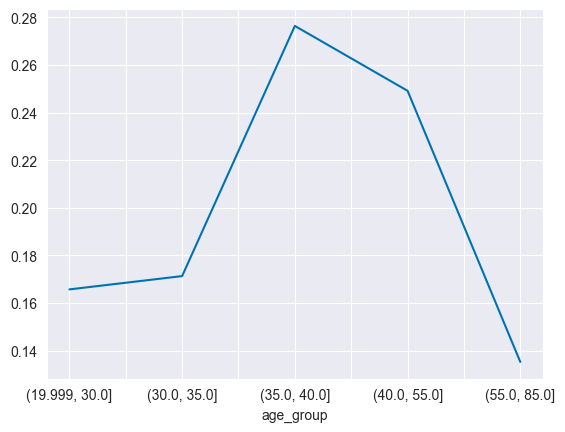

In [43]:
df_copy.groupby('age_group').smoking.mean().plot();

Курят больше людей в возрасте 35-40, те кто моложе и старше - меньше

### height - НЕТ зависимости

In [72]:
df_copy['height_group'] = pd.qcut(df_copy['height_cm_'], 5, duplicates='drop')

In [84]:
df_copy.groupby('height_group').smoking.agg(['count', 'mean']).sort_values('mean', ascending=False)

,count,mean
height_group,,
"(170.0, 175.0]",3013,0.222038
"(165.0, 170.0]",4222,0.211748
"(175.0, 190.0]",1505,0.194020
"(144.999, 165.0]",5069,0.184455


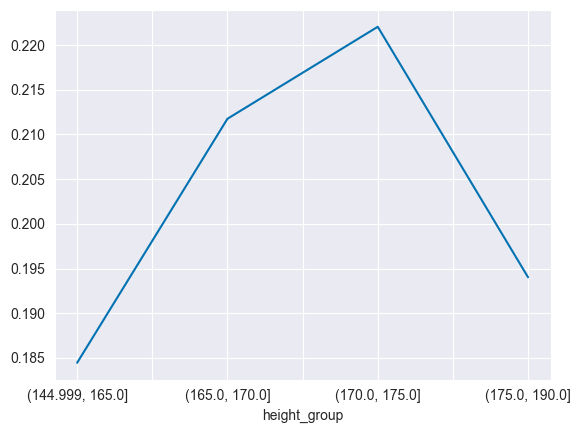

In [73]:
# plt.figure(figsize=(16, 5))
df_copy.groupby('height_group').smoking.mean().plot();

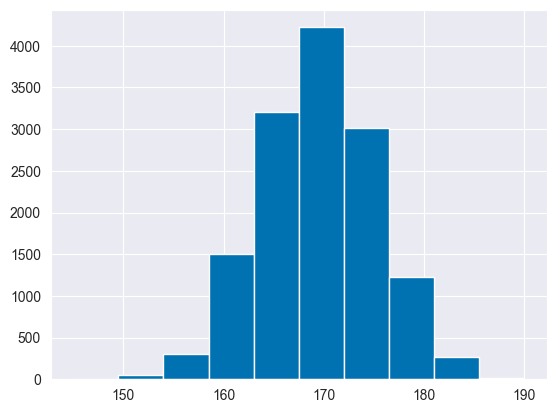

In [74]:
df_copy.height_cm_.hist();

### Weight - есть зависимость

In [82]:
df_copy['weight_group'] = pd.qcut(df_copy['weight_kg_'], 5, duplicates='drop')

In [85]:
df_copy.groupby('weight_group').smoking.agg(['count', 'mean']).sort_values('mean', ascending=False)

,count,mean
weight_group,,
"(80.0, 130.0]",2009,0.230463
"(75.0, 80.0]",1478,0.206360
"(39.999, 60.0]",2924,0.201436
"(60.0, 70.0]",5193,0.195841
"(70.0, 75.0]",2205,0.188662


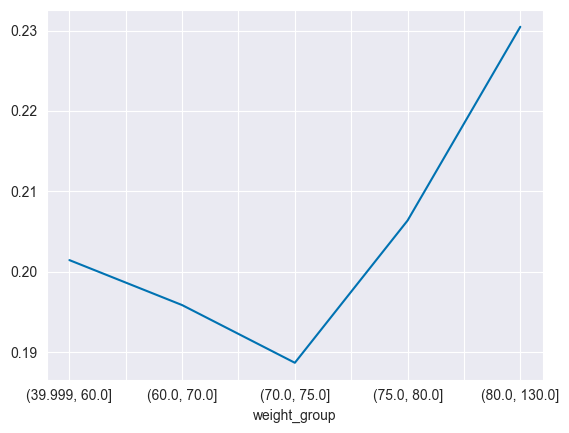

In [83]:
df_copy.groupby('weight_group').smoking.mean().plot();

Люди с большим весом чаще курят

### Waist - есть зависимость

In [86]:
df_copy['waist_group'] = pd.qcut(df_copy['waist_cm_'], 5, duplicates='drop')

In [87]:
df_copy.groupby('waist_group').smoking.agg(['count', 'mean']).sort_values('mean', ascending=False)

,count,mean
waist_group,,
"(91.0, 120.9]",2727,0.222956
"(50.999, 78.0]",2879,0.204585
"(86.2, 91.0]",2792,0.203797
"(78.0, 82.5]",2717,0.190283
"(82.5, 86.2]",2694,0.188196


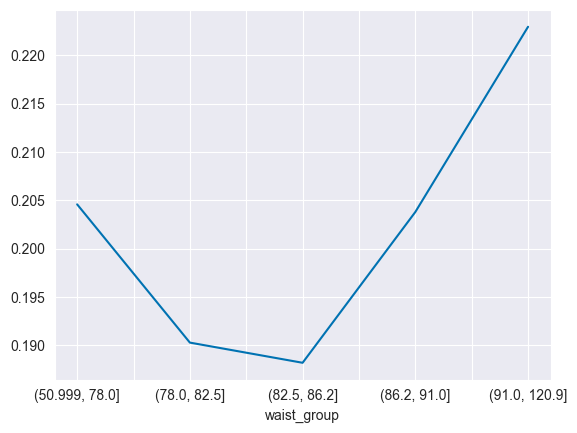

In [88]:
df_copy.groupby('waist_group').smoking.mean().plot();

Люди с большей талией чаще курят

### Eyesight right - НЕТ зависимости

In [90]:
df_copy['eyesight_right_group'] = pd.qcut(df_copy['eyesight_right_'], 5, duplicates='drop')

In [91]:
df_copy.groupby('eyesight_right_group').smoking.agg(['count', 'mean']).sort_values('mean', ascending=False)

,count,mean
eyesight_right_group,,
"(1.2, 9.9]",2473,0.207440
"(0.8, 1.0]",4331,0.201570
"(0.099, 0.8]",3593,0.201503
"(1.0, 1.2]",3412,0.199297


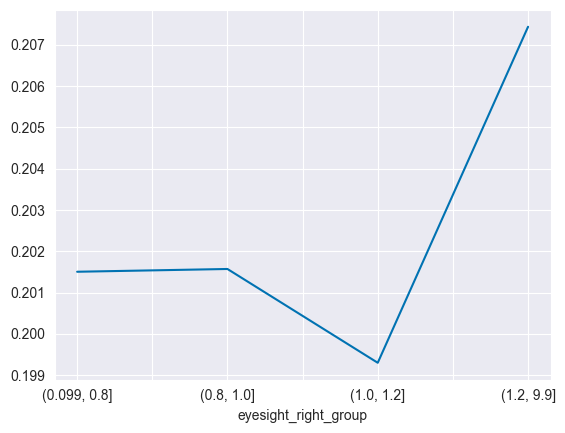

In [92]:
df_copy.groupby('eyesight_right_group').smoking.mean().plot();

### Eyesight left - НЕТ зависимости

In [93]:
df_copy['eyesight_left_group'] = pd.qcut(df_copy['eyesight_left_'], 5, duplicates='drop')

In [94]:
df_copy.groupby('eyesight_left_group').smoking.agg(['count', 'mean']).sort_values('mean', ascending=False)

,count,mean
eyesight_left_group,,
"(1.0, 1.2]",3549,0.204001
"(0.099, 0.8]",3569,0.202578
"(0.8, 1.0]",4194,0.201001
"(1.2, 9.9]",2497,0.200240


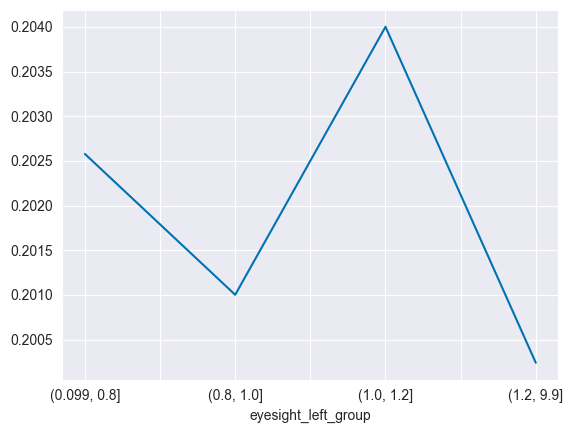

In [95]:
df_copy.groupby('eyesight_left_group').smoking.mean().plot();

### Urine protein - НЕТ зависимости

In [101]:
df_copy['urine_protein_group'] = pd.qcut(df_copy['urine_protein'], 2, duplicates='drop')

In [102]:
df_copy.groupby('urine_protein_group').smoking.agg(['count', 'mean']).sort_values('mean', ascending=False)

,count,mean
urine_protein_group,,
"(0.999, 6.0]",13809,0.202042


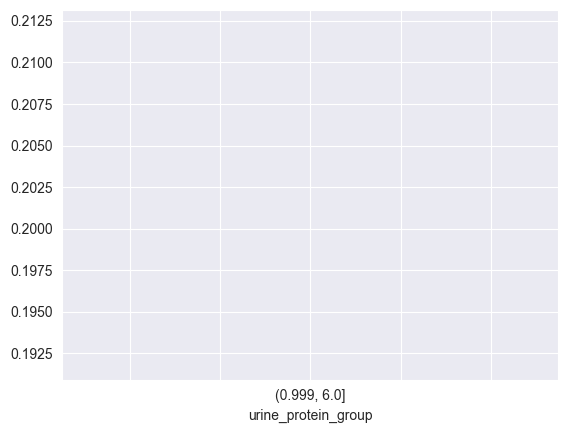

In [103]:
df_copy.groupby('urine_protein_group').smoking.mean().plot();

### Dental caries - НЕТ зависимости

In [112]:
df_copy['dental_caries_group'] = pd.qcut(df_copy['dental_caries'], 2, duplicates='drop')

In [113]:
df_copy.groupby('dental_caries_group').smoking.agg(['count', 'mean']).sort_values('mean', ascending=False)

,count,mean
dental_caries_group,,
"(-0.001, 1.0]",13809,0.202042


In [115]:
df_copy.groupby('dental_caries').smoking.mean()

dental_caries
0    0.190275
1    0.245734
Name: smoking, dtype: float64

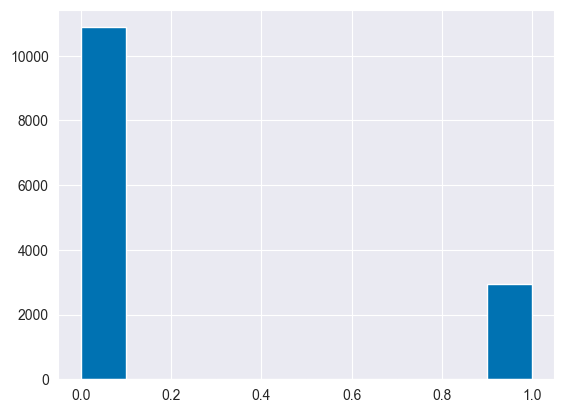

In [109]:
df_copy.dental_caries.hist();

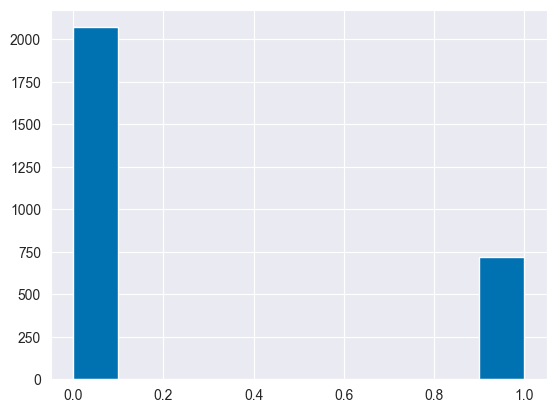

In [124]:
df_copy.query('smoking == 1').dental_caries.hist();

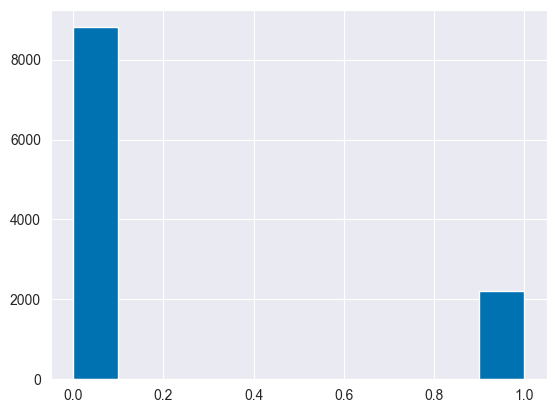

In [125]:
df_copy.query('smoking == 0').dental_caries.hist();

### tartar - НЕТ зависимости

In [119]:
df.head()

,id,age,height_cm_,weight_kg_,waist_cm_,eyesight_left_,eyesight_right_,hearing_left_,hearing_right_,systolic,relaxation,fasting_blood_sugar,cholesterol,triglyceride,hdl,ldl,hemoglobin,urine_protein,serum_creatinine,ast,alt,gtp,oral,dental_caries,tartar,smoking
0,2791,65,170,75,91.0,0.6,0.9,1.0,1.0,122.0,79.0,107.0,119.0,51.0,71.0,52.0,14.0,3.0,1.2,20.0,16.0,122.0,Y,0,N,0
1,18280,35,170,85,97.0,1.5,1.5,1.0,1.0,138.0,88.0,117.0,204.0,239.0,46.0,120.0,14.6,1.0,0.7,20.0,25.0,40.0,Y,0,Y,1
2,1618,70,165,55,75.0,0.8,1.0,1.0,1.0,115.0,63.0,128.0,165.0,60.0,68.0,85.0,14.7,1.0,0.7,15.0,13.0,19.0,Y,0,Y,0
3,16856,35,180,85,83.0,1.2,1.0,1.0,1.0,130.0,80.0,100.0,209.0,155.0,53.0,125.0,17.2,1.0,0.8,22.0,18.0,17.0,Y,0,Y,0
4,5885,25,170,65,80.0,1.5,1.2,1.0,1.0,135.0,75.0,94.0,153.0,73.0,58.0,80.0,16.5,1.0,1.0,20.0,13.0,14.0,Y,0,Y,1


In [116]:
df_copy.groupby('tartar').smoking.mean()

tartar
N    0.172736
Y    0.226745
Name: smoking, dtype: float64

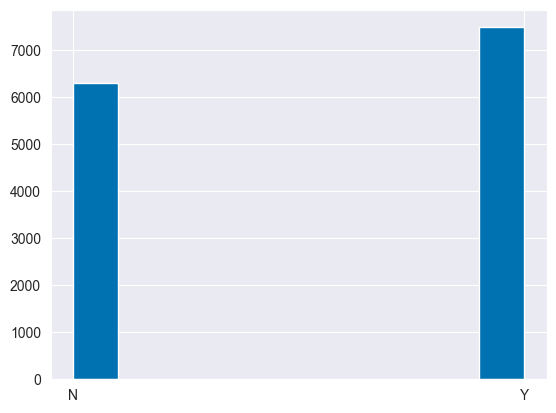

In [117]:
df_copy.tartar.hist();

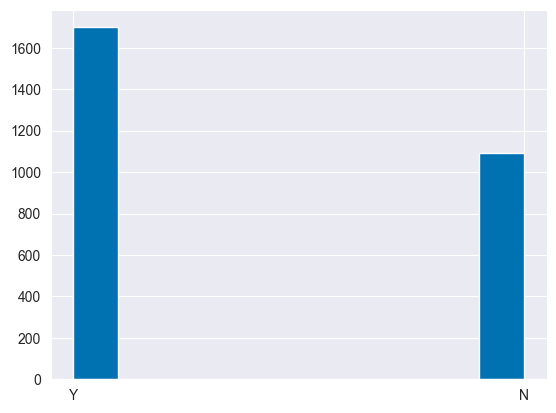

In [122]:
df_copy.query('smoking == 1').tartar.hist();

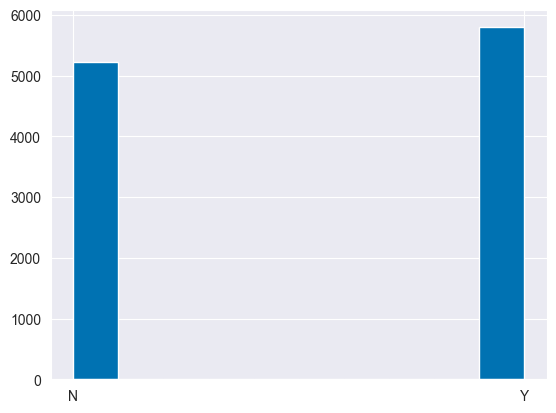

In [123]:
df_copy.query('smoking == 0').tartar.hist();